In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from time import time

pitch = pd.read_excel("reduced_centrocampistas.xlsx")

numeric_vars = ['Transfer_value', 'Exp_contr', 'Age', 'Minutes_pl', 'Minutes_pl_BC', 'NP_goals', 'Pen_goals', 'Pen_goals_BC', 'Assists', 'Interceptions', 'GCA_BC', 'Yellow_cards', 'Red_cards']
pitch[numeric_vars] = StandardScaler().fit_transform(pitch[numeric_vars])

In [4]:
ind_vars = ['Exp_contr', 'Age', 'Minutes_pl', 'Minutes_pl_BC',
       'NP_goals', 'Pen_goals', 'Pen_goals_BC', 'Assists', 'Interceptions',
       'GCA_BC', 'Yellow_cards', 'Red_cards', 'Reduced_team_from_Inter',
       'Reduced_team_from_AC Milan', 'Reduced_team_from_Juventus',
       'Reduced_team_from_Napoli', 'Reduced_team_from_Paris SG',
       'Reduced_team_from_Real Madrid', 'Reduced_team_from_Barcelona',
       'Reduced_team_from_Atlético Madrid', 'Reduced_team_from_Bayern Munich',
       'Reduced_team_from_Bor. Dortmund', 'Reduced_team_from_Chelsea',
       'Reduced_team_from_Arsenal', 'Reduced_team_from_Man City',
       'Reduced_team_from_Man Utd', 'Reduced_team_from_Liverpool', 'Reduced_country_from_Inglaterra',
       'Reduced_country_from_Francia', 'Reduced_country_from_España',
       'Reduced_country_from_Italia', 'Reduced_country_from_Alemania',
       'Reduced_country_from_Portugal', 'Reduced_country_from_Países Bajos',
       'Reduced_country_from_Argentina', 'Reduced_country_from_Brasil']

PermutationExplainer explainer: 888it [03:29,  4.24it/s]                                                               
C:\Users\elias\AppData\Local\Temp\ipykernel_6164\3792056890.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, feature_names = ind_vars)


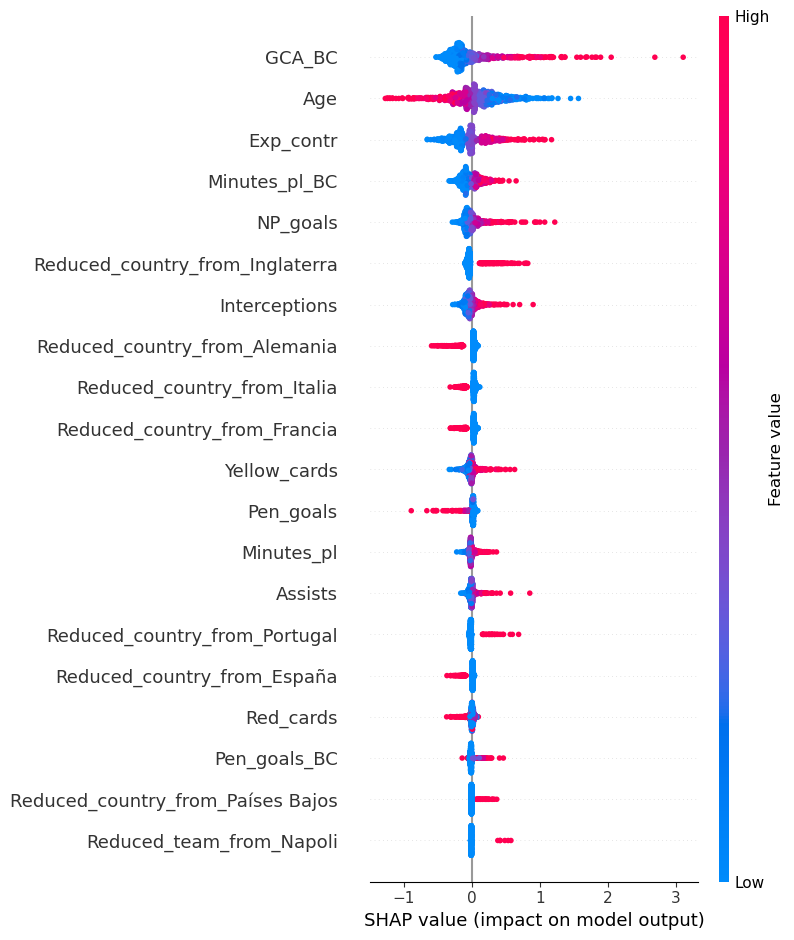

In [6]:
from tensorflow.keras.models import load_model
import shap

modelo_cargado = load_model("centrocampistas_2.keras")
X = np.array(pitch[ind_vars])  # Asegúrate de usar las variables significativas

explainer = shap.Explainer(modelo_cargado, X)  # No necesitas un masker explícito aquí
shap_values = explainer(X)

shap.summary_plot(shap_values, X, feature_names = ind_vars)

In [3]:
res = pd.DataFrame({
    'dropouts': [],
    'neurons_1': [],
    'neurons_2': [],
    'activations': [],
    'optimizers': [],
    'loss_function': [],
    'batchs': [],
    'loss': [],
    'val_loss': [],
    'Epochs': [],
    'R2': [],
    'MAE': []
})

In [4]:
time0 = time()

# 450 pruebas

dropouts = [0, 0.1, 0.2]
neurons_1 = [64, 128, 256, 512, 1024]
neurons_2 = [16, 32, 64, 128, 256, 512]
activations = ['relu']
optimizers = ['adam', 'rmsprop']
loss_f = ['mae']
batchs = [8, 16, 32, 64, 128]      
         
max_r2 = -10
for dropout in dropouts:
    for n1 in neurons_1:
        for n2 in neurons_2:
            for activation in activations:
                for optimizer in optimizers:
                    for loss in loss_f:
                        
                        print([dropout, n1, n2, activation, optimizer, loss])
                        print(time() - time0)
                            
                        for batch in batchs:  
                            
                            X = np.array(pitch[ind_vars])  # Asegúrate de usar las variables significativas
                            Y = pitch['Transfer_value']  # Variable dependiente

                            model = Sequential([
                                Dense(n1, activation=activation, input_shape=(X.shape[1],)),
                                Dropout(dropout),
                                Dense(n2, activation=activation),
                                Dropout(dropout),
                                Dense(1)
                            ])

                            model.compile(optimizer=optimizer, loss=loss)

                            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

                            history = model.fit(X, Y, epochs=75, batch_size=batch, validation_split=0.2, callbacks=[early_stop], verbose=0);

                            y_pred = model.predict(X)

                
                            r2 = r2_score(Y, y_pred)

                            mae = mean_absolute_error(Y, y_pred)
                            
                            i = history.history['val_loss'].index(min(history.history['val_loss']))
                            l = history.history['loss'][i]
                            vl = history.history['val_loss'][i]
                            
                            nueva_fila = {'dropouts': dropout, 'neurons_1': n1, 'neurons_2': n2, 'activations': activation, 'optimizers': optimizer, 
                                          'loss_function': loss, 'batchs': batch, 'loss': l, 'val_loss': vl, 'Epochs': len(history.epoch), 'R2': r2, 'MAE': mae}
                            serie_nueva_fila = pd.Series(nueva_fila, name=len(res)) # El 'name' se convierte en el índice
                            res = pd.concat([res, pd.DataFrame([nueva_fila])], ignore_index=True)
                            
                            if r2 > max_r2:
                                best_model = model
                                max_r2 = r2

[0, 64, 16, 'relu', 'adam', 'mae']
0.0009930133819580078



28/28 [==============================] - 0s 2ms/step
[0, 64, 16, 'relu', 'rmsprop', 'mae']
12.499671697616577
28/28 [==============================] - 0s 1ms/step
[0, 64, 32, 'relu', 'adam', 'mae']
23.664714336395264
28/28 [==============================] - 0s 1ms/step
[0, 64, 32, 'relu', 'rmsprop', 'mae']
34.30409812927246
28/28 [==============================] - 0s 2ms/step
[0, 64, 64, 'relu', 'adam', 'mae']
43.54200220108032
28/28 [==============================] - 0s 1ms/step
[0, 64, 64, 'relu', 'rmsprop', 'mae']
54.59100151062012
28/28 [==============================] - 0s 1ms/step
[0, 64, 128, 'relu', 'adam', 'mae']
64.03627133369446
28/28 [==============================] - 0s 2ms/step
[0, 64, 128, 'relu', 'rmsprop', 'mae']
74.2175645828247
28/28 [==============================] - 0s 1ms/step
[0, 64, 256, 'relu', 'adam', 'mae']
81.99097776412964
28/28 [==============================] - 0s 1ms/step
[0, 64, 256, 'relu', 'r

28/28 [==============================] - 0s 2ms/step
[0, 1024, 32, 'relu', 'adam', 'mae']
481.4721908569336
28/28 [==============================] - 0s 2ms/step
[0, 1024, 32, 'relu', 'rmsprop', 'mae']
491.8375494480133
28/28 [==============================] - 0s 2ms/step
[0, 1024, 64, 'relu', 'adam', 'mae']
500.8159317970276
28/28 [==============================] - 0s 2ms/step
[0, 1024, 64, 'relu', 'rmsprop', 'mae']
511.57023310661316
28/28 [==============================] - 0s 2ms/step
[0, 1024, 128, 'relu', 'adam', 'mae']
521.1886320114136
28/28 [==============================] - 0s 2ms/step
[0, 1024, 128, 'relu', 'rmsprop', 'mae']
532.7780647277832
28/28 [==============================] - 0s 2ms/step
[0, 1024, 256, 'relu', 'adam', 'mae']
543.9734840393066
28/28 [==============================] - 0s 2ms/step
[0, 1024, 256, 'relu', 'rmsprop', 'mae']
555.9529204368591
28/28 [==============================] - 0s 2ms/step
[0, 1024, 512, 'relu', 'adam', 'mae']
568.4676744937897
28/28 [===

28/28 [==============================] - 0s 1ms/step
[0.1, 512, 64, 'relu', 'adam', 'mae']
1035.3444888591766
28/28 [==============================] - 0s 1ms/step
[0.1, 512, 64, 'relu', 'rmsprop', 'mae']
1045.168108701706
28/28 [==============================] - 0s 1ms/step
[0.1, 512, 128, 'relu', 'adam', 'mae']
1054.661654472351
28/28 [==============================] - 0s 2ms/step
[0.1, 512, 128, 'relu', 'rmsprop', 'mae']
1066.6290967464447
28/28 [==============================] - 0s 2ms/step
[0.1, 512, 256, 'relu', 'adam', 'mae']
1079.3383004665375
28/28 [==============================] - 0s 2ms/step
[0.1, 512, 256, 'relu', 'rmsprop', 'mae']
1090.6204767227173
28/28 [==============================] - 0s 2ms/step
[0.1, 512, 512, 'relu', 'adam', 'mae']
1102.3467972278595
28/28 [==============================] - 0s 2ms/step
[0.1, 512, 512, 'relu', 'rmsprop', 'mae']
1119.1221408843994
28/28 [==============================] - 0s 2ms/step
[0.1, 1024, 16, 'relu', 'adam', 'mae']
1131.8370583

28/28 [==============================] - 0s 2ms/step
[0.2, 64, 128, 'relu', 'adam', 'mae']
1375.7083027362823
28/28 [==============================] - 0s 2ms/step
[0.2, 64, 128, 'relu', 'rmsprop', 'mae']
1387.9089319705963
28/28 [==============================] - 0s 2ms/step
[0.2, 64, 256, 'relu', 'adam', 'mae']
1400.1757349967957
28/28 [==============================] - 0s 2ms/step
[0.2, 64, 256, 'relu', 'rmsprop', 'mae']
1410.9778683185577
28/28 [==============================] - 0s 2ms/step
[0.2, 64, 512, 'relu', 'adam', 'mae']
1424.6717755794525
28/28 [==============================] - 0s 2ms/step
[0.2, 64, 512, 'relu', 'rmsprop', 'mae']
1438.2941687107086
28/28 [==============================] - 0s 2ms/step
[0.2, 128, 16, 'relu', 'adam', 'mae']
1449.191516160965
28/28 [==============================] - 0s 2ms/step
[0.2, 128, 16, 'relu', 'rmsprop', 'mae']
1463.5577654838562
28/28 [==============================] - 0s 2ms/step
[0.2, 128, 32, 'relu', 'adam', 'mae']
1475.2735240459442

28/28 [==============================] - 0s 2ms/step
[0.2, 256, 128, 'relu', 'rmsprop', 'mae']
1680.9716901779175
28/28 [==============================] - 0s 2ms/step
[0.2, 256, 256, 'relu', 'adam', 'mae']
1691.1199924945831
28/28 [==============================] - 0s 2ms/step
[0.2, 256, 256, 'relu', 'rmsprop', 'mae']
1703.3693363666534
28/28 [==============================] - 0s 2ms/step
[0.2, 256, 512, 'relu', 'adam', 'mae']
1714.599868774414
28/28 [==============================] - 0s 2ms/step
[0.2, 256, 512, 'relu', 'rmsprop', 'mae']
1729.5361092090607
28/28 [==============================] - 0s 2ms/step
[0.2, 512, 16, 'relu', 'adam', 'mae']
1743.1705930233002
28/28 [==============================] - 0s 2ms/step
[0.2, 512, 16, 'relu', 'rmsprop', 'mae']
1754.3207037448883
28/28 [==============================] - 0s 2ms/step
[0.2, 512, 32, 'relu', 'adam', 'mae']
1763.817046403885
28/28 [==============================] - 0s 2ms/step
[0.2, 512, 32, 'relu', 'rmsprop', 'mae']
1775.025936

In [5]:
res.sort_values(by='R2', ascending=False)

,dropouts,neurons_1,neurons_2,activations,optimizers,loss_function,batchs,loss,val_loss,Epochs,R2,MAE
531,0.1,512.0,512.0,relu,adam,mae,16.0,0.300035,0.329082,14.0,0.732725,0.274479
250,0.0,1024.0,32.0,relu,adam,mae,8.0,0.299640,0.322255,12.0,0.731330,0.269968
295,0.0,1024.0,512.0,relu,rmsprop,mae,8.0,0.308571,0.325235,12.0,0.728573,0.278993
465,0.1,256.0,256.0,relu,rmsprop,mae,8.0,0.315711,0.330240,15.0,0.720406,0.273252
870,0.2,1024.0,128.0,relu,adam,mae,8.0,0.323086,0.332804,13.0,0.706260,0.293761
...,...,...,...,...,...,...,...,...,...,...,...,...
487,0.1,512.0,16.0,relu,rmsprop,mae,32.0,0.445597,0.312340,7.0,0.408461,0.378607
873,0.2,1024.0,128.0,relu,adam,mae,64.0,0.475620,0.317225,7.0,0.394978,0.390031
512,0.1,512.0,128.0,relu,adam,mae,32.0,0.519869,0.323615,6.0,0.390723,0.406760
267,0.0,1024.0,64.0,relu,rmsprop,mae,32.0,0.490368,0.328081,6.0,0.375386,0.393796


In [6]:
# from tensorflow.keras.models import load_model

# # Cargar el modelo
# modelo_cargado = load_model("defensas_2.keras")

best_model.save("centrocampistas_2.keras")

# 0.1	512.0	512.0	relu	adam	mae	16.0	0.300035	0.329082	14.0	0.732725	0.274479

In [10]:
res_2 = pd.DataFrame({
    'dropouts': [],
    'neurons_1': [],
    'neurons_2': [],
    'neurons_3': [],
    'activations': [],
    'optimizers': [],
    'loss_function': [],
    'batchs': [],
    'loss': [],
    'val_loss': [],
    'Epochs': [],
    'R2': [],
    'MAE': []
})

In [11]:
time0 = time()

# 1323 pruebas

dropouts = [0.2]  # 0.1, 0.2, 0.3, 0.4
neurons_1 = [16, 32, 64, 128, 256, 512, 1024]
neurons_2 = [8, 16, 32, 64, 128, 256, 512]
neurons_3 = [2, 3, 4]
activations = ['relu']
optimizers = ['adam', 'rmsprop']
loss_f = ['mae']
batchs = [8, 16, 32]      

max_r2 = -10
for dropout in dropouts:
    for n1 in neurons_1:
        for n2 in neurons_2:
            for n3 in neurons_3:
                print([dropout, n1, n2, n3])
                print(time() - time0)
                for activation in activations:
                    for optimizer in optimizers:
                        for loss in loss_f:                            
                            for batch in batchs:  

                                X = np.array(pitch[ind_vars])  # Asegúrate de usar las variables significativas
                                Y = pitch['Transfer_value']  # Variable dependiente

                                model = Sequential([
                                    Dense(n1, activation=activation, input_shape=(X.shape[1],)),
                                    Dropout(dropout),
                                    Dense(n2, activation=activation),
                                    Dropout(dropout),
                                    Dense(n3, activation=activation),
                                    Dropout(dropout),
                                    Dense(1)
                                ])

                                model.compile(optimizer=optimizer, loss=loss)

                                early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

                                history = model.fit(X, Y, epochs=75, batch_size=batch, validation_split=0.2, callbacks=[early_stop], verbose=0);

                                y_pred = model.predict(X, verbose=0)


                                r2 = r2_score(Y, y_pred)

                                mae = mean_absolute_error(Y, y_pred)

                                i = history.history['val_loss'].index(min(history.history['val_loss']))
                                l = history.history['loss'][i]
                                vl = history.history['val_loss'][i]

                                nueva_fila = {'dropouts': dropout, 'neurons_1': n1, 'neurons_2': n2, 'neurons_3': n3, 'activations': activation, 'optimizers': optimizer, 
                                              'loss_function': loss, 'batchs': batch, 'loss': l, 'val_loss': vl, 'Epochs': len(history.epoch), 'R2': r2, 'MAE': mae}
                                serie_nueva_fila = pd.Series(nueva_fila, name=len(res_2)) # El 'name' se convierte en el índice
                                res_2 = pd.concat([res_2, pd.DataFrame([nueva_fila])], ignore_index=True)    
                                
                                if r2 > max_r2:
                                    best_model = model
                                    max_r2 = r2

[0.1, 16, 8, 2]
0.004996061325073242
[0.1, 16, 8, 3]
262.24619007110596
[0.1, 16, 8, 4]
499.7321994304657
[0.1, 16, 16, 2]
734.9066534042358
[0.1, 16, 16, 3]
944.51589012146
[0.1, 16, 16, 4]
1043.0778632164001
[0.1, 16, 32, 2]
1090.730560541153
[0.1, 16, 32, 3]
1129.6545424461365
[0.1, 16, 32, 4]
1165.8620209693909
[0.1, 16, 64, 2]
1195.4489960670471
[0.1, 16, 64, 3]
1228.8106005191803
[0.1, 16, 64, 4]
1254.7222971916199
[0.1, 16, 128, 2]
1281.642582654953
[0.1, 16, 128, 3]
1305.8778612613678
[0.1, 16, 128, 4]
1331.1015186309814
[0.1, 16, 256, 2]
1357.1819717884064
[0.1, 16, 256, 3]
1383.2651371955872
[0.1, 16, 256, 4]
1416.043965101242
[0.1, 16, 512, 2]
1443.2183585166931
[0.1, 16, 512, 3]
1474.8287031650543
[0.1, 16, 512, 4]
1500.9368817806244
[0.1, 32, 8, 2]
1524.596931219101
[0.1, 32, 8, 3]
1553.0775773525238
[0.1, 32, 8, 4]
1582.3381805419922
[0.1, 32, 16, 2]
1610.3471171855927
[0.1, 32, 16, 3]
1637.1839740276337
[0.1, 32, 16, 4]
1665.9562547206879
[0.1, 32, 32, 2]
1690.2183315753

In [12]:
res_2.sort_values(by='R2', ascending=False)

,dropouts,neurons_1,neurons_2,neurons_3,activations,optimizers,loss_function,batchs,loss,val_loss,Epochs,R2,MAE
613,0.1,256.0,512.0,2.0,relu,adam,mae,16.0,0.321108,0.353422,24.0,0.767006,0.285343
733,0.1,512.0,256.0,4.0,relu,adam,mae,16.0,0.261835,0.344625,27.0,0.761362,0.262392
623,0.1,256.0,512.0,3.0,relu,rmsprop,mae,32.0,0.308593,0.369748,34.0,0.749219,0.292887
464,0.1,128.0,128.0,4.0,relu,adam,mae,32.0,0.303564,0.341132,40.0,0.728645,0.284496
817,0.1,1024.0,64.0,3.0,relu,adam,mae,16.0,0.302096,0.333712,23.0,0.716963,0.294964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,0.1,512.0,512.0,3.0,relu,adam,mae,32.0,0.588212,0.459179,48.0,-0.142330,0.562302
739,0.1,512.0,512.0,2.0,relu,adam,mae,16.0,0.588258,0.459179,31.0,-0.142579,0.562303
452,0.1,128.0,128.0,2.0,relu,adam,mae,32.0,0.588271,0.459179,46.0,-0.142805,0.562305
489,0.1,128.0,512.0,2.0,relu,rmsprop,mae,8.0,0.588319,0.459179,22.0,-0.144365,0.562317


In [13]:
res_2.to_excel("NN_3_2.xlsx" ,index=False)
best_model.save("centrocampistas_3_2.keras")

In [2]:
# best_model.save("centrocampistas_3_0.keras")

n3_0 = pd.read_excel("NN_3_0.xlsx")
n3_1 = pd.read_excel("NN_3_1.xlsx")
n3 = pd.concat([n3_0, n3_1], ignore_index=True)  

n3.sort_values(by='R2', ascending=False)

,dropouts,neurons_1,neurons_2,neurons_3,activations,optimizers,loss_function,batchs,loss,val_loss,Epochs,R2,MAE
845,0.0,1024,128,4,relu,rmsprop,mae,32,0.250804,0.376732,33,0.789231,0.265614
535,0.0,256,16,4,relu,adam,mae,16,0.239220,0.369970,22,0.787690,0.248188
638,0.0,512,8,3,relu,adam,mae,32,0.229668,0.373292,33,0.779004,0.251578
1495,0.1,256,512,2,relu,adam,mae,16,0.321108,0.353422,24,0.767006,0.285343
722,0.0,512,256,2,relu,adam,mae,32,0.286629,0.397644,25,0.765066,0.287252
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,0.1,128,512,2,relu,rmsprop,mae,8,0.588319,0.459179,22,-0.144365,0.562317
621,0.0,256,512,3,relu,rmsprop,mae,8,0.588368,0.459179,22,-0.144771,0.562320
813,0.0,1024,64,2,relu,rmsprop,mae,8,0.588347,0.459179,21,-0.144984,0.562321
371,0.0,64,512,3,relu,rmsprop,mae,32,0.588205,0.459179,41,-0.145444,0.562325


In [19]:
from tensorflow.keras.models import load_model

modelo_cargado = load_model("defensas_3.keras")
y_pred = modelo_cargado.predict(X, verbose=0)

r2 = r2_score(Y, y_pred)
mae = mean_absolute_error(Y, y_pred)

print(r2, mae)

0.8536836891040274 0.21307662941951247
